In [217]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations

In [207]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [101]:
random.seed(12345)
fixed_tree = ete3.Tree()
tree_size  = 10
taxa       = []
loop_count = 0
while len(taxa) < tree_size:
    if tree_size <= 25:
        for chr_number in range(97, 97+tree_size):
            taxa.append(chr(chr_number))
    else:
        loop_count += 1
        for chr_number in range(97, 123):
            taxa.append('%s%i' %(chr(chr_number), loop_count))
        taxa = taxa[:tree_size]
            
taxa = set(taxa)
fixed_tree.populate(size=tree_size, names_library=taxa, random_branches=True)
for node in fixed_tree.traverse():
    node.img_style["size"] = 0
fixed_tree.dist = 0.1
print(fixed_tree)


         /-g
      /-|
     |  |   /-c
     |   \-|
     |      \-d
   /-|
  |  |      /-e
  |  |   /-|
  |  |  |   \-f
  |   \-|
  |     |   /-j
--|      \-|
  |        |   /-b
  |         \-|
  |            \-i
  |
  |   /-a
   \-|
      \-h


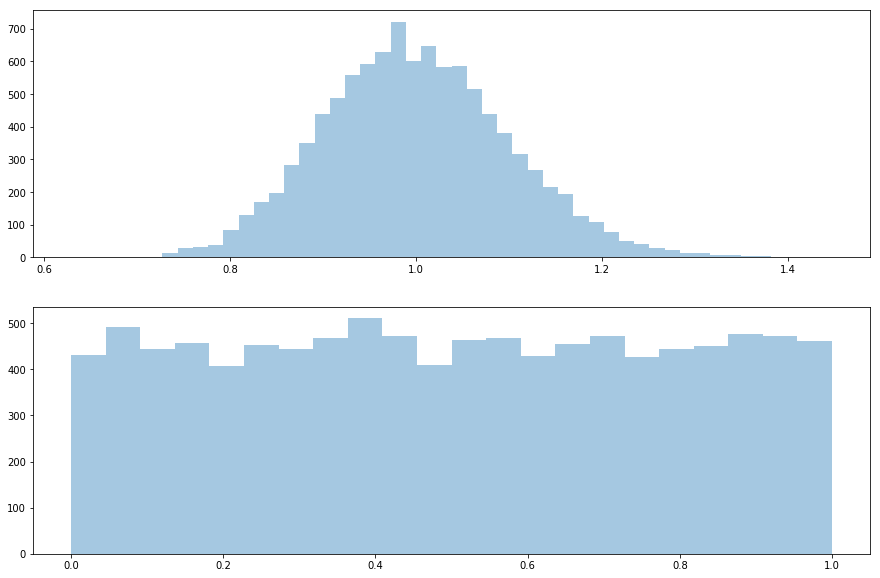

In [166]:
with pm.Model() as model:
    alpha = 1/np.mean([node.dist for node in fixed_tree.traverse()
                       if not node.is_root()])
    br_length_scale   = pm.Gamma('br_length_scale', 100, 100)
    point_of_transfer = pm.Uniform('point_of_transfer', lower=0, upper=1)

fig, axs = plt.subplots(figsize=(15, 10), nrows=2)
sample   = br_length_scale.random(size=10000)
sns.distplot(sample, kde=False, ax=axs[0])
sample   = point_of_transfer.random(size=10000)
sns.distplot(sample, kde=False, ax=axs[1])

In [134]:
ts = ete3.TreeStyle()
ts.show_branch_length = True

np.random.seed(12345)
random.seed(12345)
tree         = fixed_tree.copy()
topologies   = [tree.copy()]
topology_ids = set(tree.get_topology_id())
tree.render(file_name="tree_%i.png" % len(topologies), dpi=100, w=500, units='px', tree_style=ts)
while len(topologies) < 10:
    starting_tree = tree.copy()
    
    pruned_node    = random.choice([node for node in tree.traverse()
                                    if tree.get_distance(node, topology_only=True) > 0]).copy()
    pruned_node.dist *= br_length_scale.random()
    
    tree.prune(taxa.difference(pruned_node.get_leaf_names()), preserve_branch_length=True)

    source = random.choice([node for node in tree.traverse()
                            if not node.is_root()])

    source.add_sister(pruned_node)
    tree.resolve_polytomy()

    topology_id = tree.get_topology_id()
    if topology_id in topology_ids:
        tree = starting_tree.copy()
        continue
    
    if pruned_node.is_leaf():
        recipient = tree.get_leaves_by_name(pruned_node.name)[0]
    else:
        recipient = tree.get_common_ancestor(pruned_node.get_leaf_names())
    parent    = recipient.get_ancestors()[0]
    donor     = recipient.get_sisters()[0]

    proportion  = point_of_transfer.random()
    parent.dist = donor.dist * proportion
    donor.dist -= donor.get_ancestors()[0].dist

    parent.img_style['size']       = 0
    donor.img_style['size'   ]     = 5
    donor.img_style['fgcolor']     = 'red'
    recipient.img_style['size'   ] = 5
    recipient.img_style['fgcolor'] = 'blue'
    
    topology_ids.add(topology_id)
    topologies.append(tree.copy())
    tree.render(file_name="tree_%i.png" % len(topologies), dpi=100, w=500, units='px', tree_style=ts)

    donor.img_style['size']        = 0
    recipient.img_style['size']    = 0

In [164]:
indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

[MODEL] model1   [submodel]  LG                         //   LG
                 [rates]     0 0.8025 12                //   pinv=0, alpha=1.3, discrete gamma categories=20
                 [statefreq]
                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
                    0.0055   0.0293   0.0535   0.0956   // A R N D C
                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
                    0.0253   0.0280   0.0415   0.0519   // L K M F P
                    0.0516   0.0065   0.0217   0.0898   // S T W Y V
                 [indelmodel]   POW  1.7 500 // Power law insertion/deletion length distribution (a=1.7)
                 [indelrate]    0.1
'''

indelible_tree_exert      = '[TREE]       {tree_name}  {newick}\n'
indelible_partition_exert = '[PARTITIONS] {partition_name} [{tree_name} model1 1000]\n'
indelible_evolve_exert    = '             {partition_name}  1   {tree_name}\n'

for count, tree in enumerate(topologies):
    indelible_conf += indelible_tree_exert.format(tree_name='tree_%i'  % count,
                                                  newick   = tree.write(format=5, dist_formatter='%.10f'))
indelible_conf += '\n'
    
for count, tree in enumerate(topologies):
    indelible_conf += indelible_partition_exert.format(partition_name='partition_%i'  % count,
                                                       tree_name     ='tree_%i'       % count)
indelible_conf += '\n'

indelible_conf += '[EVOLVE]     {partition_name}  1   {tree_name}\n'.format(
    partition_name='partition_0',
    tree_name     ='tree_0')
for count, tree in enumerate(topologies[1:], 1):
    indelible_conf += indelible_evolve_exert.format(partition_name='partition_%i'  % count,
                                                    tree_name     ='tree_%i'       % count)

out = open('control.txt', 'w')
out.write(indelible_conf)
out.close()

#print(indelible_conf)

In [176]:
for count, tree in enumerate(topologies):
    tree.write(outfile='trees/tree_%i.nwk' % count, format=5, dist_formatter='%.10f')
    shutil.copy('tree_%i_True.phy' % count, 'alignments/tree_%i.phy' % count)

In [185]:
geodesic_dists = pd.read_csv('geodesic_distances.tab', sep='\t', index_col=0)
rf_dists       = pd.read_csv(      'rf_distances.tab', sep='\t', index_col=0)
geodesic_dists

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,1.101037,1.293737,1.304605,2.215588,3.412975,3.486295,3.017502,2.913838,2.999929
tree_1,1.101037,0.000000,1.138118,1.192144,2.203243,3.418982,3.492075,3.015997,2.909833,2.980899
tree_2,1.293737,1.138118,0.000000,0.357207,2.134782,3.643390,3.714794,3.281369,3.185330,3.276302
tree_3,1.304605,1.192144,0.357207,0.000000,2.066723,3.644989,3.716363,3.282516,3.187426,3.278332
tree_4,2.215588,2.203243,2.134782,2.066723,0.000000,3.638591,3.710087,3.622212,3.605163,3.743030
tree_5,3.412975,3.418982,3.643390,3.644989,3.638591,0.000000,1.334713,2.026070,3.385938,3.629525
tree_6,3.486295,3.492075,3.714794,3.716363,3.710087,1.334713,0.000000,1.524303,3.216206,3.449531
tree_7,3.017502,3.015997,3.281369,3.282516,3.622212,2.026070,1.524303,0.000000,2.832045,3.094473
tree_8,2.913838,2.909833,3.185330,3.187426,3.605163,3.385938,3.216206,2.832045,0.000000,2.878365
tree_9,2.999929,2.980899,3.276302,3.278332,3.743030,3.629525,3.449531,3.094473,2.878365,0.000000


In [373]:
geodesic_dists = pd.read_csv('geodesic_distances.tab', sep='\t', index_col=0)
rf_dists       = pd.read_csv(      'rf_distances.tab', sep='\t', index_col=0)
geodesic_dists

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,1.371166,2.220563,1.285509,2.426657,3.637670,3.756118,2.499684,3.097251,3.223113
tree_1,1.371166,0.000000,1.924379,1.442672,2.309221,3.553486,3.722288,2.468338,3.069717,3.074371
tree_2,2.220563,1.924379,0.000000,2.152743,2.335205,4.758778,4.906700,3.817644,4.315129,4.294229
tree_3,1.285509,1.442672,2.152743,0.000000,2.236230,3.570992,3.677327,2.317746,2.923057,3.082843
tree_4,2.426657,2.309221,2.335205,2.236230,0.000000,3.974950,4.332562,3.415000,3.974998,4.055328
tree_5,3.637670,3.553486,4.758778,3.570992,3.974950,0.000000,1.860991,2.323895,3.127688,3.602727
tree_6,3.756118,3.722288,4.906700,3.677327,4.332562,1.860991,0.000000,1.989669,2.459462,3.797821
tree_7,2.499684,2.468338,3.817644,2.317746,3.415000,2.323895,1.989669,0.000000,2.067411,2.719880
tree_8,3.097251,3.069717,4.315129,2.923057,3.974998,3.127688,2.459462,2.067411,0.000000,2.792408
tree_9,3.223113,3.074371,4.294229,3.082843,4.055328,3.602727,3.797821,2.719880,2.792408,0.000000


In [189]:
spr_distances  = pd.DataFrame(index=geodesic_dists.index,
                              columns=geodesic_dists.index,
                              data=[abs(np.arange(10)-n) for n in range(10)])
spr_distances

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0,1,2,3,4,5,6,7,8,9
tree_1,1,0,1,2,3,4,5,6,7,8
tree_2,2,1,0,1,2,3,4,5,6,7
tree_3,3,2,1,0,1,2,3,4,5,6
tree_4,4,3,2,1,0,1,2,3,4,5
tree_5,5,4,3,2,1,0,1,2,3,4
tree_6,6,5,4,3,2,1,0,1,2,3
tree_7,7,6,5,4,3,2,1,0,1,2
tree_8,8,7,6,5,4,3,2,1,0,1
tree_9,9,8,7,6,5,4,3,2,1,0


SPR vs Geodesic corr: 0.4340
SPR vs RF corr: 0.7041


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


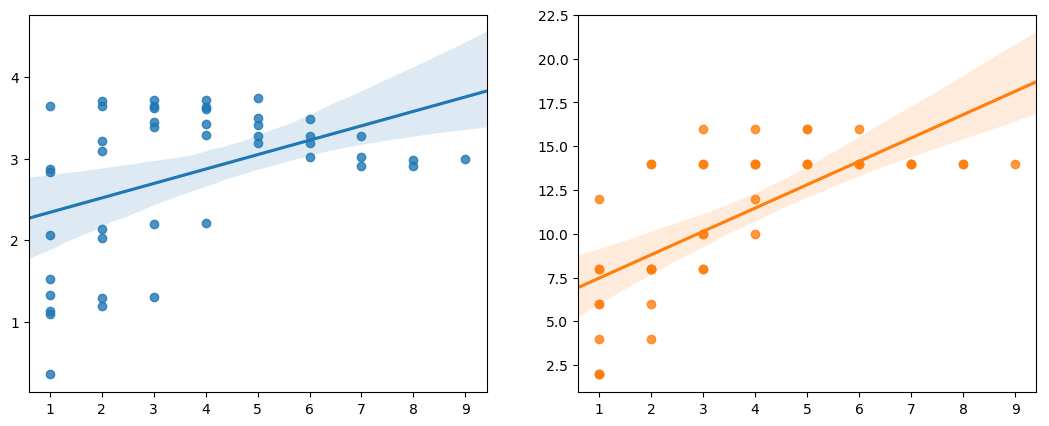

In [206]:
print('SPR vs Geodesic corr: %.4f'
      % pearsonr(squareform(spr_distances.values), squareform(geodesic_dists.values))[0])
print('SPR vs RF corr: %.4f'
      % pearsonr(squareform(spr_distances.values), squareform(rf_dists.values))[0])
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(13, 5))
sns.regplot(x=squareform(spr_distances.values), y=squareform(geodesic_dists.values), ax=axs[0])
sns.regplot(x=squareform(spr_distances.values), y=squareform(      rf_dists.values), ax=axs[1])

SPR vs Geodesic corr: 0.3869
SPR vs RF corr: 0.6314


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


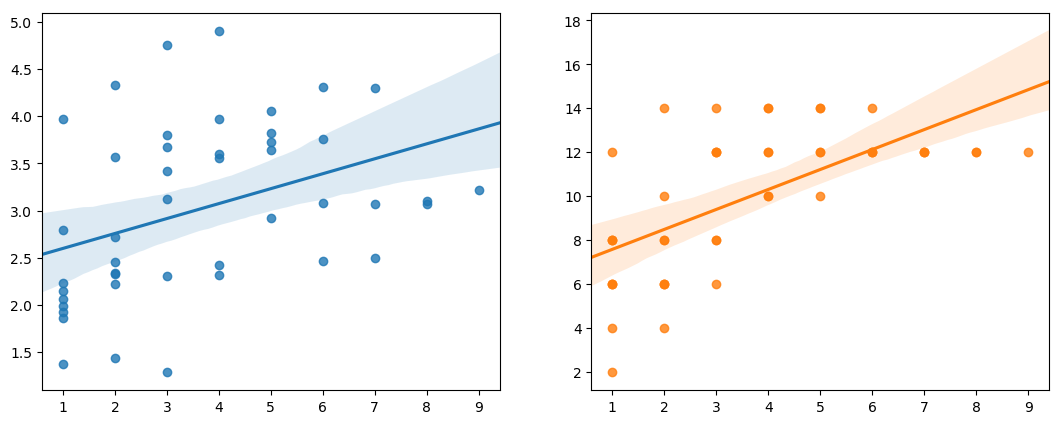

In [374]:
print('SPR vs Geodesic corr: %.4f'
      % pearsonr(squareform(spr_distances.values), squareform(geodesic_dists.values))[0])
print('SPR vs RF corr: %.4f'
      % pearsonr(squareform(spr_distances.values), squareform(rf_dists.values))[0])
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(13, 5))
sns.regplot(x=squareform(spr_distances.values), y=squareform(geodesic_dists.values), ax=axs[0])
sns.regplot(x=squareform(spr_distances.values), y=squareform(      rf_dists.values), ax=axs[1])

In [370]:
distance_matrices = {}
taxa_order = 'a b c d e f g h i j'.split()
with cd('alignments/'):
    for filename in os.listdir('.'):
        if not filename.endswith('.phy'):
            continue
        subprocess.call([
            'iqtree',
            '-s', filename,
            '-pre', filename.split('.')[0],
#            '-te', 'BIONJ',
            '-m', 'LG+G',
            '-safe',
            '-keep-ident',
            '-redo',
            '-seed', '12345',
        ])
        
        indexes = []
        values  = []
        for line in open('%s.mldist' % filename.split('.')[0]).readlines()[1:]:
            line = line.split()
            indexes.append(line[0])
            values.append(line[1:])
        distance_matrices[filename.split('.')[0]] = pd.DataFrame(
            index=indexes,
            columns=indexes, 
            data=values, 
            dtype=float
        ).reindex(index  =taxa_order,
                  columns=taxa_order)

In [372]:
for filename in os.listdir('alignments/'):
    if filename.endswith('.treefile'):
        tree_name = filename.replace('.treefile', '')
        shutil.copy('alignments/%s' % filename,
                    'trees/%s.nwk' % tree_name)

In [240]:
family_corrs = []
for family1, family2 in combinations(geodesic_dists.index, 2):
    family_corrs.append(
        pearsonr(
            squareform(distance_matrices[family1].values),
            squareform(distance_matrices[family2].values)
    )[0])
family_corrs = pd.DataFrame(index=geodesic_dists.index,
                            columns=geodesic_dists.columns,
                            data=squareform(family_corrs))
family_corrs

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.449829,0.564504,0.510897,0.402659,0.032644,0.038545,0.093174,0.211448,0.121088
tree_1,0.449829,0.000000,0.593602,0.370422,0.335482,-0.248913,-0.015542,0.269740,0.188342,-0.027062
tree_2,0.564504,0.593602,0.000000,0.679783,0.713431,-0.172695,-0.008460,0.096245,0.281133,0.168755
tree_3,0.510897,0.370422,0.679783,0.000000,0.583092,0.055334,0.031062,0.133191,0.199405,0.206338
tree_4,0.402659,0.335482,0.713431,0.583092,0.000000,0.001482,0.089143,-0.139628,0.283009,0.057463
tree_5,0.032644,-0.248913,-0.172695,0.055334,0.001482,0.000000,0.283659,0.143087,0.167448,0.421515
tree_6,0.038545,-0.015542,-0.008460,0.031062,0.089143,0.283659,0.000000,0.273520,0.621018,0.263072
tree_7,0.093174,0.269740,0.096245,0.133191,-0.139628,0.143087,0.273520,0.000000,0.100966,0.252667
tree_8,0.211448,0.188342,0.281133,0.199405,0.283009,0.167448,0.621018,0.100966,0.000000,0.243479
tree_9,0.121088,-0.027062,0.168755,0.206338,0.057463,0.421515,0.263072,0.252667,0.243479,0.000000


In [312]:
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr
from sklearn.metrics import mean_squared_error

In [398]:
def huber_loss(residuals, epsilon=1.35):
    # https://en.wikipedia.org/wiki/Huber_loss
    corrected_residuals = []
    for error in residuals:
        if abs(error) <= epsilon:
            corrected_residuals.append((error**2)/2)
        else:
            corrected_residuals.append(epsilon*(abs(error)-epsilon/2))
    return(np.mean(corrected_residuals))

In [368]:
X = squareform(distance_matrices['tree_1'].values)
Y = squareform(distance_matrices['tree_2'].values)
X = X.reshape(-1, 1)
huber_thresh       = 1.35
huber_model        = hr(epsilon=huber_thresh, fit_intercept=False).fit(X, Y)
least_square_model = lr(                      fit_intercept=False).fit(X, Y)

huber_y        =        huber_model.predict(X)
least_square_y = least_square_model.predict(X)
print(huber_loss(huber_y-Y), mean_squared_error(least_square_y, Y))

0.7461150316264384 1.456287923080473


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


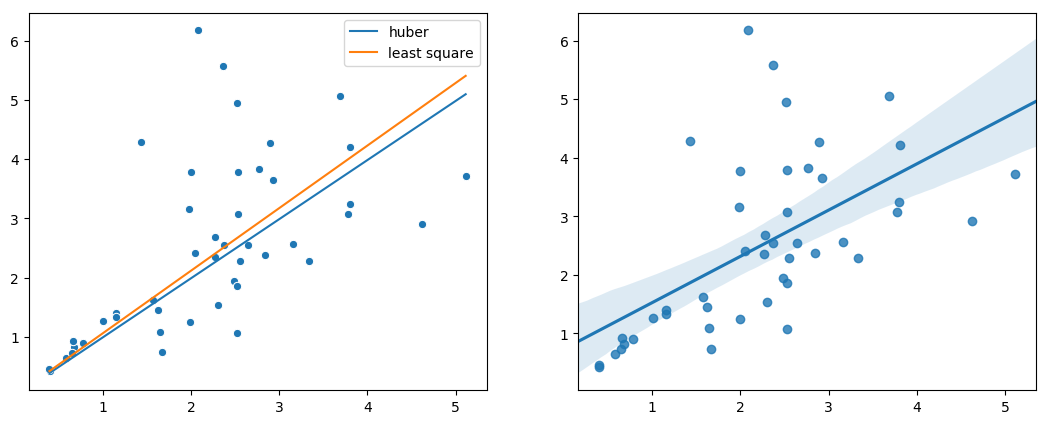

In [369]:
fig, axs = plt.subplots(dpi=100, figsize=(13, 5), ncols=2)
sns.scatterplot(x=X.reshape(1, -1)[0], y=Y, ax=axs[0])
sns.lineplot(x=[X.reshape(1, -1)[0].min(), X.reshape(1, -1)[0].max()],
             y=[pred_y.min(), pred_y.max()],
             ax=axs[0],
             label='huber')
sns.lineplot(x=[X.reshape(1, -1)[0].min(), X.reshape(1, -1)[0].max()],
             y=[least_square_y.min(), least_square_y.max()],
             ax=axs[0],
             label='least square')
sns.regplot(x=X.reshape(1, -1)[0], y=Y, ax=axs[1])

In [280]:
least_square = []
for family1, family2 in combinations(geodesic_dists.index, 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)
    X = X.reshape(-1, 1)
    regression = lm.LinearRegression(fit_intercept=False).fit(X, Y)

    pred_y = regression.predict(X)
    least_square.append(sum((pred_y-Y)**2))

least_square = pd.DataFrame(index=geodesic_dists.index,
                            columns=geodesic_dists.columns,
                            data=squareform(least_square))
least_square

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,69.761520,82.977061,220.226568,100.002008,750.713248,205.445085,104.246161,98.812309,108.010123
tree_1,69.761520,0.000000,65.532957,256.480141,93.586311,815.277244,190.356126,70.529855,82.818106,97.085400
tree_2,82.977061,65.532957,0.000000,159.627760,47.038176,835.915505,204.282730,96.893643,84.423450,94.306532
tree_3,220.226568,256.480141,159.627760,0.000000,107.897379,905.231269,258.227954,141.225119,143.531723,151.612674
tree_4,100.002008,93.586311,47.038176,107.897379,0.000000,750.173141,191.130199,121.194917,86.578918,108.320125
tree_5,750.713248,815.277244,835.915505,905.231269,750.173141,0.000000,181.478398,119.066341,124.779404,99.651413
tree_6,205.445085,190.356126,204.282730,258.227954,191.130199,181.478398,0.000000,98.451143,61.602457,110.162221
tree_7,104.246161,70.529855,96.893643,141.225119,121.194917,119.066341,98.451143,0.000000,94.358020,76.559220
tree_8,98.812309,82.818106,84.423450,143.531723,86.578918,124.779404,61.602457,94.358020,0.000000,76.407624
tree_9,108.010123,97.085400,94.306532,151.612674,108.320125,99.651413,110.162221,76.559220,76.407624,0.000000


In [405]:
huber = []
huber_thresh = 1.35
for family1, family2 in combinations(geodesic_dists.index, 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)
    
    regression = hr(epsilon=huber_thresh, fit_intercept=False).fit(X.reshape(-1, 1), Y)
    pred_y     = regression.predict(X.reshape(-1, 1))
    loss_xy    = huber_loss(Y-pred_y)
    
    regression = hr(epsilon=huber_thresh, fit_intercept=False).fit(Y.reshape(-1, 1), X)
    pred_x     = regression.predict(Y.reshape(-1, 1))
    loss_yx    = huber_loss(X-pred_x)
    
    if loss_xy < loss_yx:
        huber.append(loss_xy)
    else:
        huber.append(loss_yx)

huber = pd.DataFrame(index=geodesic_dists.index,
                            columns=geodesic_dists.columns,
                            data=squareform(huber))
huber

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.437468,0.482636,0.894934,0.659491,1.217681,0.968299,0.802398,0.681704,0.734205
tree_1,0.437468,0.000000,0.479761,1.120034,0.743588,1.405953,1.053439,0.663823,0.704096,0.831065
tree_2,0.482636,0.479761,0.000000,0.830832,0.466420,1.656330,1.269386,0.864336,0.752798,0.805919
tree_3,0.894934,1.120034,0.830832,0.000000,0.909719,2.018967,1.606677,1.243725,1.211972,1.288746
tree_4,0.659491,0.743588,0.466420,0.909719,0.000000,1.392528,1.103181,0.993594,0.732757,0.938529
tree_5,1.217681,1.405953,1.656330,2.018967,1.392528,0.000000,1.187426,0.910581,1.199806,0.953615
tree_6,0.968299,1.053439,1.269386,1.606677,1.103181,1.187426,0.000000,0.780947,0.595475,0.916758
tree_7,0.802398,0.663823,0.864336,1.243725,0.993594,0.910581,0.780947,0.000000,0.771203,0.582815
tree_8,0.681704,0.704096,0.752798,1.211972,0.732757,1.199806,0.595475,0.771203,0.000000,0.677799
tree_9,0.734205,0.831065,0.805919,1.288746,0.938529,0.953615,0.916758,0.582815,0.677799,0.000000


In [346]:
huber.sum()

tree_0    11.721256
tree_1    10.629433
tree_2    11.195181
tree_3    14.318803
tree_4    11.274797
tree_5    24.237987
tree_6    10.814521
tree_7     8.501823
tree_8     7.739689
tree_9     8.628364
dtype: float64

In [406]:
huber.sum()

tree_0     6.878817
tree_1     7.439227
tree_2     7.608420
tree_3    11.125606
tree_4     7.939807
tree_5    11.942888
tree_6     9.481587
tree_7     7.613423
tree_8     7.327610
tree_9     7.729450
dtype: float64

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


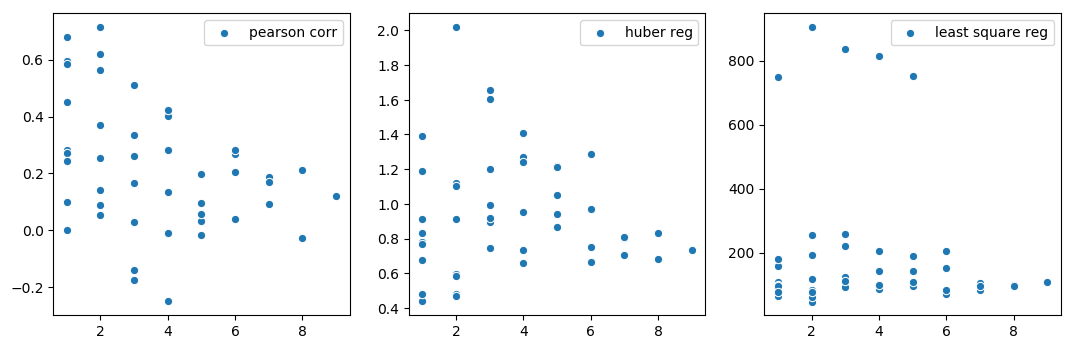

In [407]:
fig, axs = plt.subplots(dpi=100, figsize=(13, 4), ncols=3)
sns.scatterplot(x=squareform(spr_distances.values),
            y=squareform(family_corrs.values),
            ax=axs[0], label='pearson corr')
sns.scatterplot(x=squareform(spr_distances.values),
            y=squareform(huber.values),
            ax=axs[1], label='huber reg')
sns.scatterplot(x=squareform(spr_distances.values), 
            y=squareform(SSEs.values), 
            ax=axs[2], label='least square reg')

In [401]:
colors = ['red' if 'tree_5' in n else 'blue'
          for n in combinations(geodesic_dists.index, 2)]

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


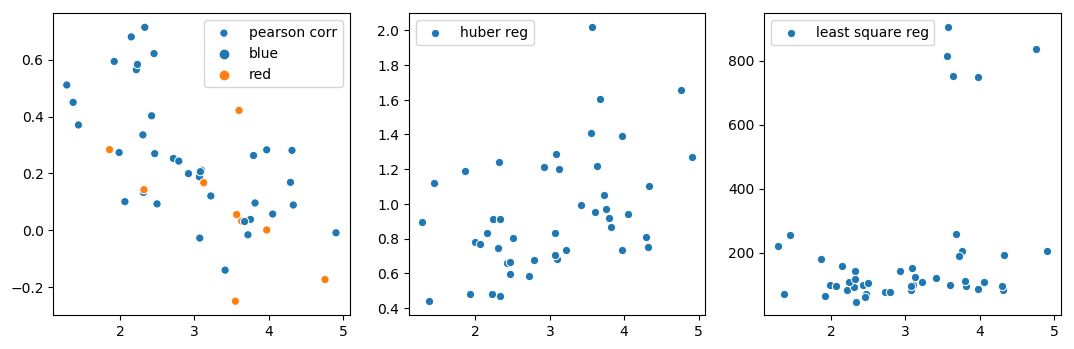

In [408]:
fig, axs = plt.subplots(dpi=100, figsize=(13, 4), ncols=3)
sns.scatterplot(x=squareform(geodesic_dists.values),
            y=squareform(family_corrs.values),
            ax=axs[0], label='pearson corr', hue=colors)
sns.scatterplot(x=squareform(geodesic_dists.values),
            y=squareform(huber.values),
            ax=axs[1], label='huber reg')
sns.scatterplot(x=squareform(geodesic_dists.values), 
            y=squareform(SSEs.values), 
            ax=axs[2], label='least square reg')

In [410]:
pearsonr(squareform(geodesic_dists.values),
         squareform(huber.values))

(0.4438472611178269, 0.0022577787080194857)

In [411]:
pearsonr(squareform(geodesic_dists.values),
         squareform(rf_dists.values))

(0.777056015863956, 3.4744425563518235e-10)